In [1]:
# Let's import the necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
from varname import nameof

import requests
from bs4 import BeautifulSoup
import html
import lxml

import sys, os

dir = os.path.dirname
sys.path.append(dir(os.getcwd()))

import src.utils.mining_data_tb as md
import src.utils.visualization_tb as vis
import src.utils.folder_tb as fo

import warnings
warnings.filterwarnings('ignore')

The purpose of my EDA is to find out whether a diet based on animal produts is efficient from a societal perspective.

This means, I'll do a cost-benefit analysis of the food animal sources and compare it to veggie alternatives.

For that purpose, I'll use the following data:
- Resources for food production (cost)
- Nutritional values of the food (benefit)

By measuring the relation between resources and nutritional values, we can determine which foods are more efficient.

# Resources

In [2]:
# First I'm gonna start analyzing the cost of the foods we eat

# Import the data
# Calculate paths to data
path1 = fo.path_to_folder(2, "data")
path2 = fo.path_to_folder(2, "data/Resources_use")

# Create the full resources dataframe
resources_df = md.get_resources_data(path1, path2)
resources_df.head()

,Total_emissions,Land use per 1000kcal,Land use per kg,Land use per 100g protein,Freswater withdrawls per 1000kcal,Freswater withdrawls per kg,Freswater withdrawls per 100g protein,Origin
Oatmeal,1.6,2.897446,7.60,5.846154,183.911552,482.4,371.076923,plant based
Rice,4.0,0.759631,2.80,3.943662,609.983722,2248.4,3166.760563,plant based
Potatoes,0.3,1.202186,0.88,5.176471,80.737705,59.1,347.647059,plant based
Cassava,0.9,1.858316,1.81,20.111111,NaN,0.0,NaN,plant based
Cane Sugar,2.6,0.581197,2.04,NaN,176.666667,620.1,NaN,plant based


Quick notes:
- All land use related data is measured in squared meters (m2)
- All water use related data is measured in liters (l)
- All emissions related data is measured in kg of CO2 per kg of food production

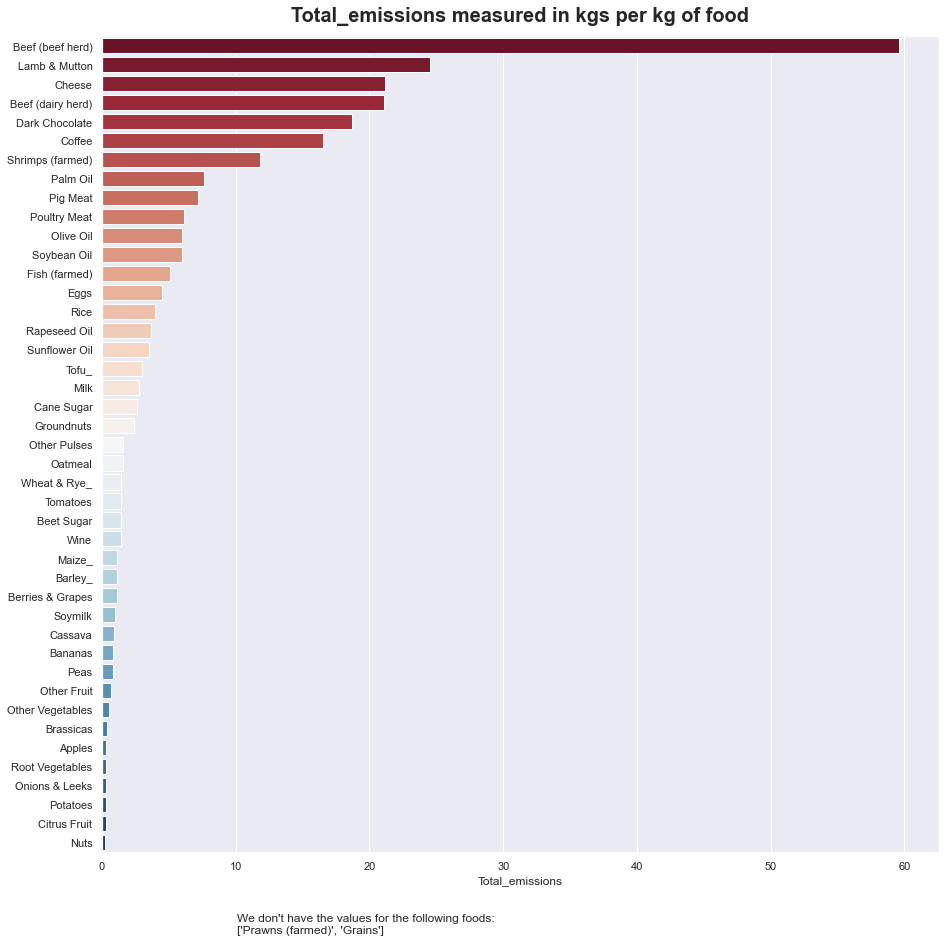

In [3]:
vis.resources_plot("Total_emissions", resources_df)
plt.show()

In [4]:
# Let's do the same for land and water use

# In those cases, we have more than one column (per kg, per 1000 kcal, per 100g of protein). I'll focus on the cost per kg as it is the best way to compare foods with such a different compositions. To produce 100g of protein based on apples, we would need quite a lot of resources, because that's not one of the key nutrients of that food. It'd be the same as measuring the amount of resources needed to get 100g of fiber from animal sources. Like way too much 

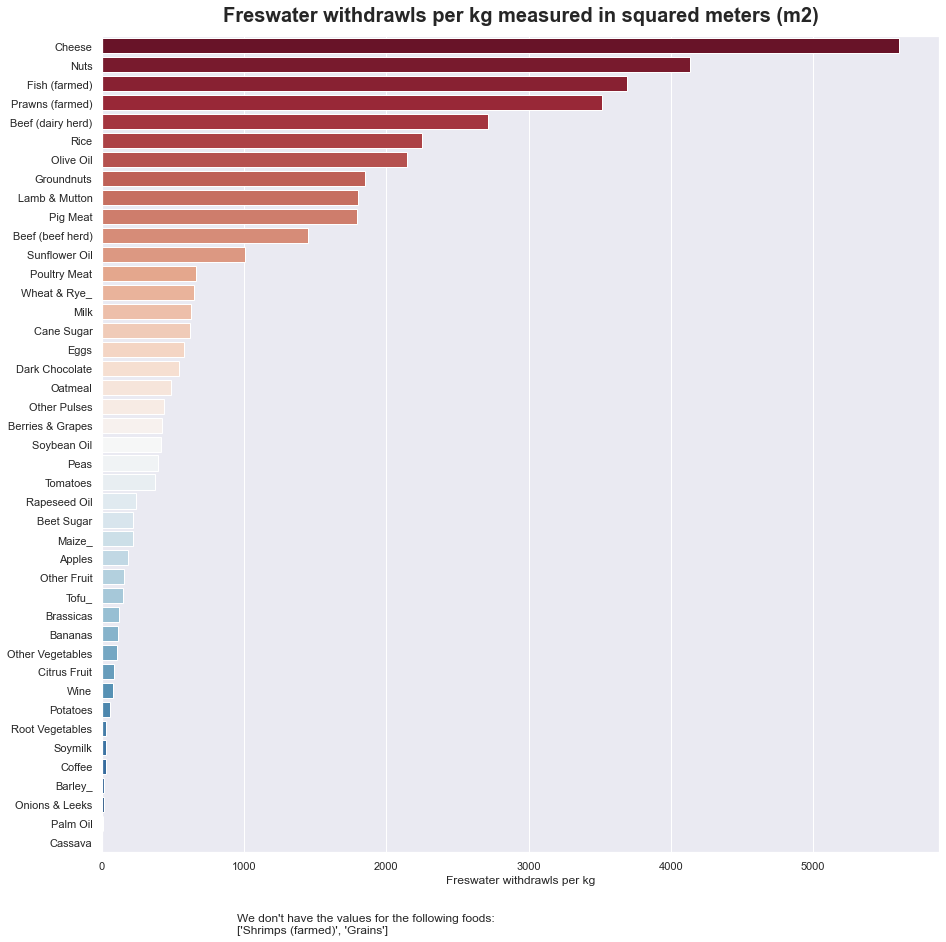

In [5]:
vis.resources_plot("Freswater withdrawls per kg", resources_df)
plt.show()

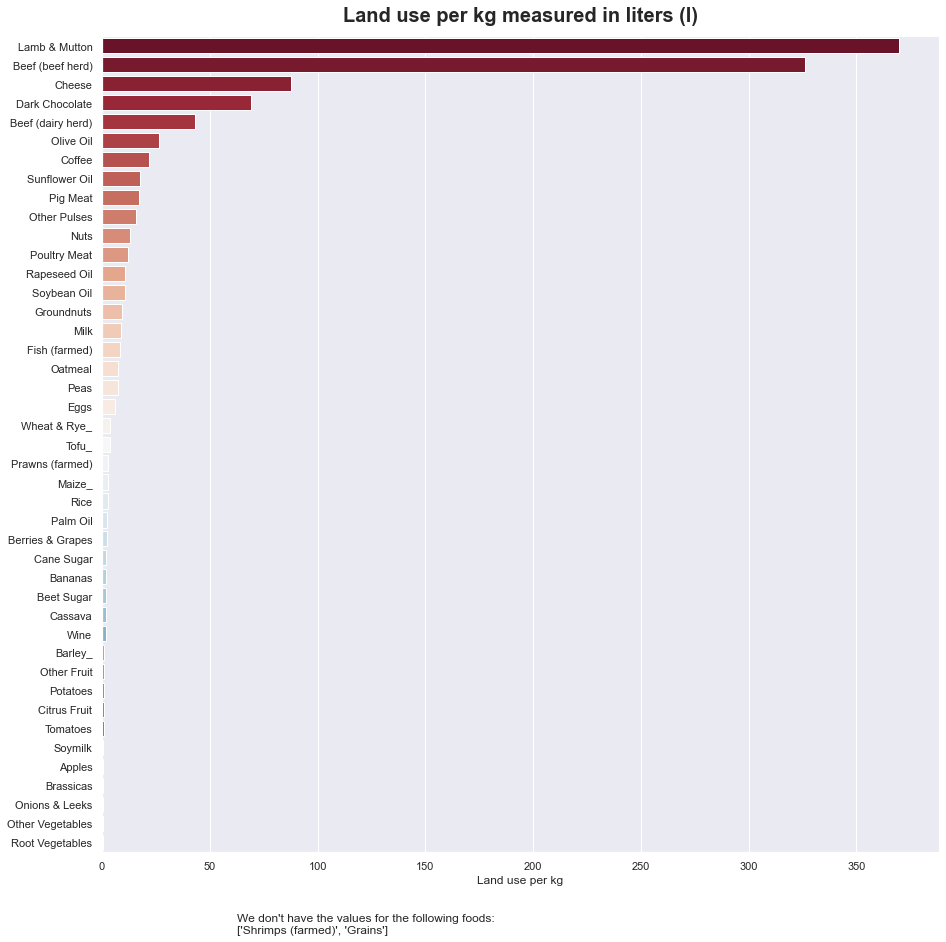

In [6]:
vis.resources_plot("Land use per kg", resources_df)
plt.show()

From this data we can already see how costly animal-based foods are from a resources standpoint compared to their plant-based counterparts.

However, to be as accurate as possible, let's see the center values comparing plant-based with animal-based

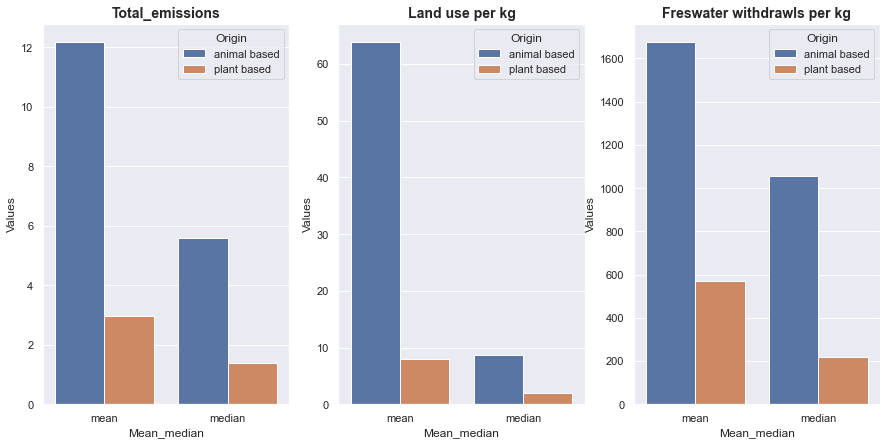

In [7]:
# Calculate stats according to origin : mean and median
stats = md.resources_stats(resources_df, ["Total_emissions", "Land use per kg", "Freswater withdrawls per kg"])
# some required transformation before plotting
to_plot = md.stats_to_plot(stats)
# plot
vis.plot_resources_stats(to_plot)
plt.show()

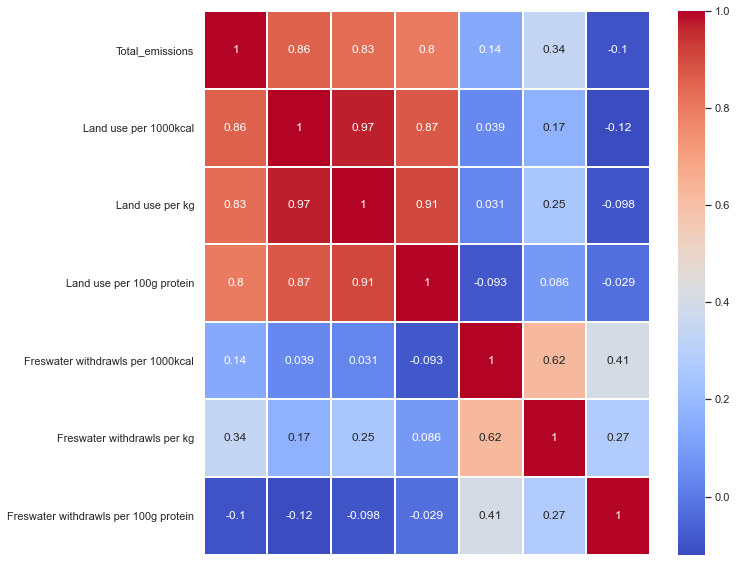

In [8]:
# The correlations here are not that interesting, but well, it doesn't hurt either
corr = resources_df.corr()
vis.correlation_plot(corr)
plt.show()

We can already conclude from this that animal-based products are much more expensive than the plant-based ones, for any category of the analysed ones.

Now, let's move on to the nutritional values analysis to see whether this "cost" difference is justified.

In [9]:
# Let's import the nutritional values data
path_nutrition = fo.path_to_folder(2, "data")
filename_nutrition = "2017-2018 FNDDS At A Glance - FNDDS Nutrient Values.xlsx"

nutrition_df = md.get_nutrition_data(path_nutrition, filename_nutrition)
nutrition_df.head()

,Category number,Category name,Protein (g),Water (g),"Fiber, total dietary (g)","Vitamin A, RAE (mcg_RAE)",Thiamin (mg),Riboflavin (mg),Niacin (mg),Vitamin B-6 (mg),...,Energy (kcal),Total Fat (g),"Fatty acids, total saturated (g)","Fatty acids, total monounsaturated (g)","Fatty acids, total polyunsaturated (g)",Cholesterol (mg),Vitamin D (D2 + D3) (mcg),Carbohydrate (g),Category 2,Category 3
Food name,,,,,,,,,,,,,,,,,,,,,
"Milk, human",9602,Human milk,1.03,87.50,0.0,61,0.014,0.036,0.177,0.011,...,70,4.38,2.009,1.658,0.497,14,0.1,6.89,milks,animal
"Milk, NFS",1004,"Milk, reduced fat",3.34,89.04,0.0,59,0.057,0.137,0.110,0.060,...,51,1.99,1.164,0.426,0.065,8,1.1,4.87,milks,animal
"Milk, whole",1002,"Milk, whole",3.28,88.10,0.0,32,0.056,0.138,0.105,0.061,...,60,3.20,1.860,0.688,0.108,12,1.1,4.67,milks,animal
"Milk, low sodium, whole",1002,"Milk, whole",3.10,88.20,0.0,29,0.020,0.105,0.043,0.034,...,61,3.46,2.154,0.999,0.128,14,1.3,4.46,milks,animal
"Milk, calcium fortified, whole",1002,"Milk, whole",3.28,88.10,0.0,32,0.056,0.138,0.105,0.061,...,60,3.20,1.860,0.688,0.108,12,1.1,4.67,milks,animal


In [20]:
# Now that we are all set, let's do some quick calculation of the mean grouped by categories, to see the average nutrients those groups have

stats = md.nutrients_stats(nutrition_df)
stats.T

Category 2,beans,cheese,chicken,fish,meats,milk_substitutes,milks,nuts,other_animal_products,other_veggie_products,soy_products
Protein (g),8.882973,20.260959,23.178750,21.006613,21.688153,1.506667,13.657712,17.534103,10.936909,6.276111,15.675714
Water (g),60.673784,51.280959,60.545580,63.887604,55.355811,85.346296,73.903644,4.731667,67.593091,58.740278,54.651429
"Fiber, total dietary (g)",7.198649,0.100000,0.159375,0.287558,0.153153,0.429630,0.096610,8.097436,0.117576,2.558333,3.985714
"Vitamin A, RAE (mcg_RAE)",2.459459,167.876712,15.071429,49.997696,135.364865,62.851852,28.550847,16.320513,174.266667,71.875000,5.190476
Thiamin (mg),0.147946,0.038397,0.089013,0.123889,0.358748,0.022074,0.083864,0.291718,0.047521,0.192750,0.986667
Riboflavin (mg),0.072365,0.326178,0.203741,0.150747,0.323032,0.104370,0.252644,0.296808,0.358691,0.130958,0.317095
Niacin (mg),0.620784,0.257000,6.596643,4.530237,5.481968,0.346074,2.443559,5.365897,0.367958,2.924569,4.460524
Vitamin B-6 (mg),0.158378,0.091808,0.402201,0.286878,0.351568,0.030222,0.138373,0.375179,0.156812,0.152431,0.400905
Vitamin B-12 (mcg),0.019730,1.082877,0.473080,3.589263,2.059640,0.408889,1.552542,0.001667,0.633273,0.067222,1.234762
"Folate, total (mcg)",98.540541,15.246575,10.468750,18.352535,17.369369,5.703704,9.093220,81.217949,28.903030,36.069444,68.047619


Well, here we can see some information, but it is difficult to determine anything

Let's visualize for instance, milks vs substitutes and see what nutrients they both have. For that purpose, I'll bring the recommended daily intake of nutrients data. This way we can compare, how much these foods fullfill the nutrient requirements

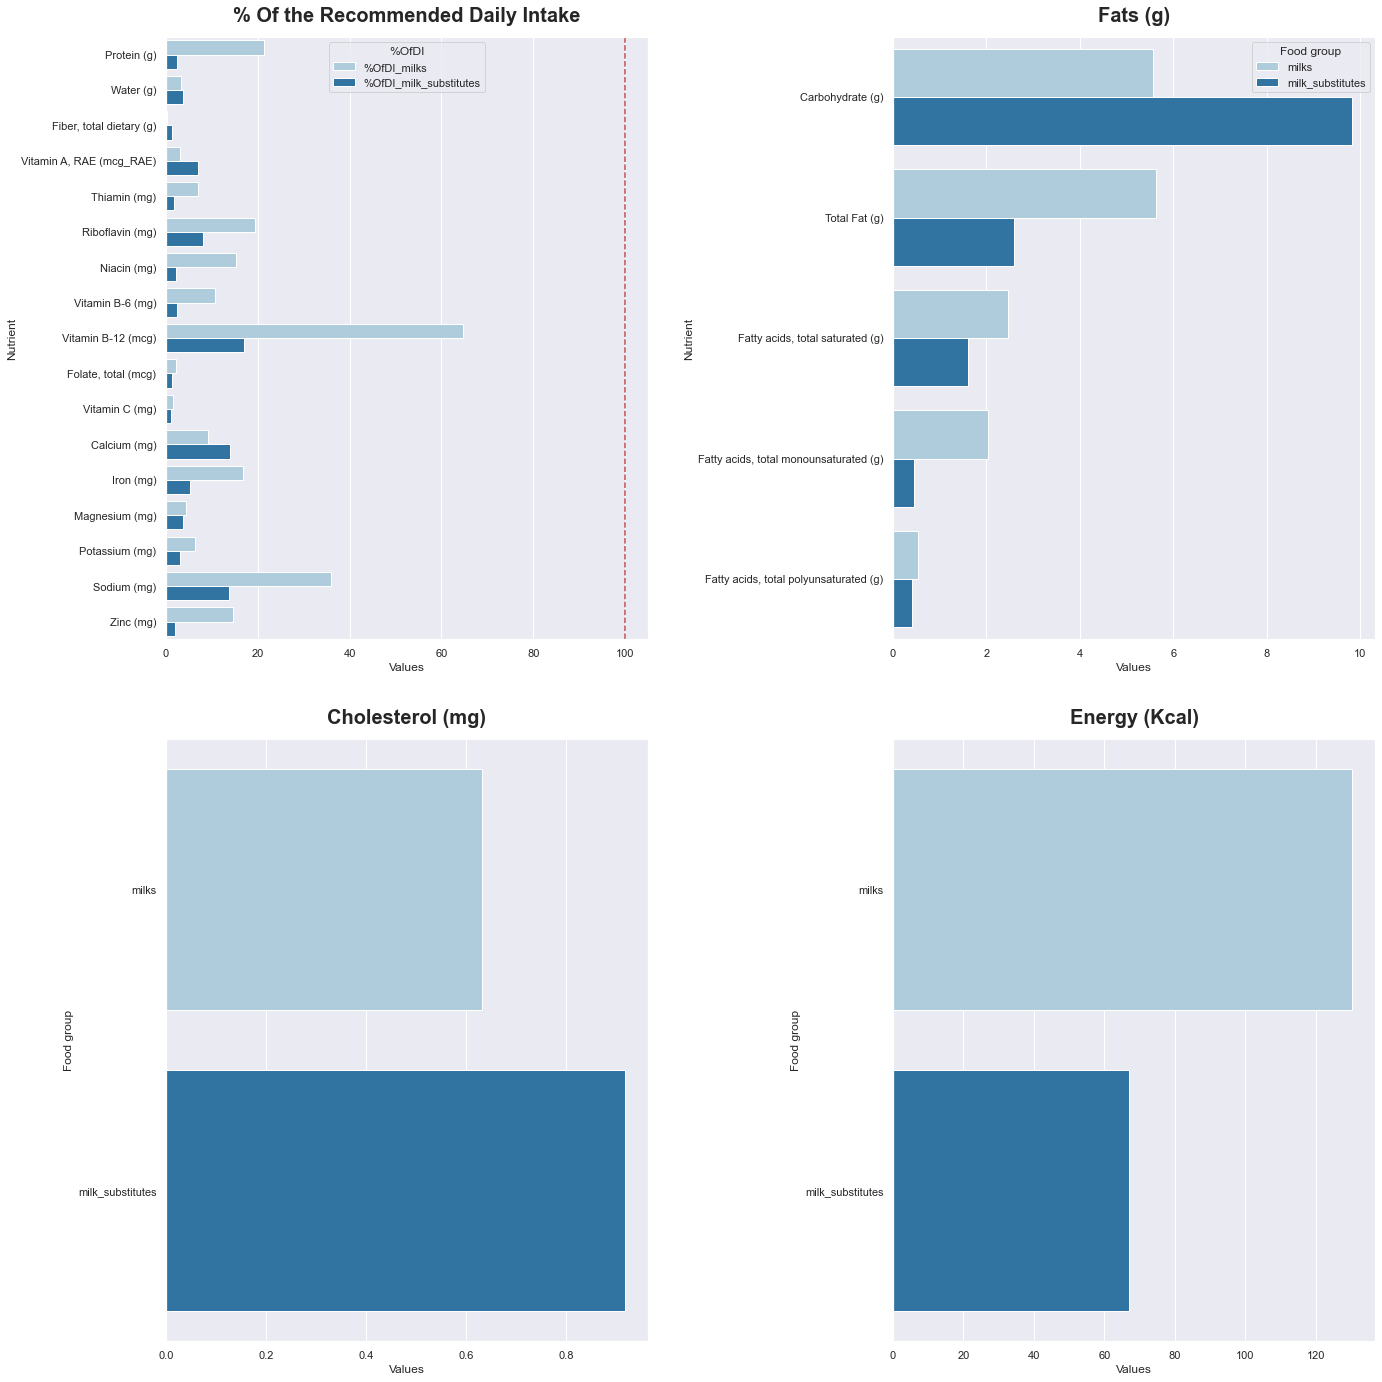

In [35]:
# We need to calculate the daily intakes
path_di = fo.path_to_folder(2, "data")
filename_di = "daily_intakes.csv"

male_30 = md.get_daily_intake_data(path_di, filename_di, "male", 30)

# Then we choose the foods (categories in this case) we want to pass in the plotter
food_groups = ["milks", "milk_substitutes"]

# We calculate the comparison
comparison1 = md.full_comparison(male_30, stats, food_groups)

# We plot this
vis.full_comparison_plot(comparison1)
plt.show()

Well, here we can see that the traditional milk is over the veggie substitutes when talking about: protein, vitamin B12, Sodium, Zinc, etc... 

On the other hand, we can also see that the traditional milk is more fat-loaded and they have higher calories.

However, as the range of products included in both milk_substitutes and milks varies a lot (for instance, milks includes yogurts and milk_substitutes includes several kinds of milk, like soy, almond, coconut, etc..), let's compare soy milk with any standard milk, to see what that looks like.

In [32]:
nutrition_df[nutrition_df["Category 2"] == "milks"].index[:15]

Index(['Milk, human', 'Milk, NFS', 'Milk, whole', 'Milk, low sodium, whole',
       'Milk, calcium fortified, whole',
       'Milk, calcium fortified, low fat (1%)',
       'Milk, calcium fortified, fat free (skim)', 'Milk, reduced fat (2%)',
       'Milk, acidophilus, low fat (1%)',
       'Milk, acidophilus, reduced fat (2%)', 'Milk, low fat (1%)',
       'Milk, fat free (skim)', 'Milk, lactose free, low fat (1%)',
       'Milk, lactose free, fat free (skim)',
       'Milk, lactose free, reduced fat (2%)'],
      dtype='object', name='Food name')

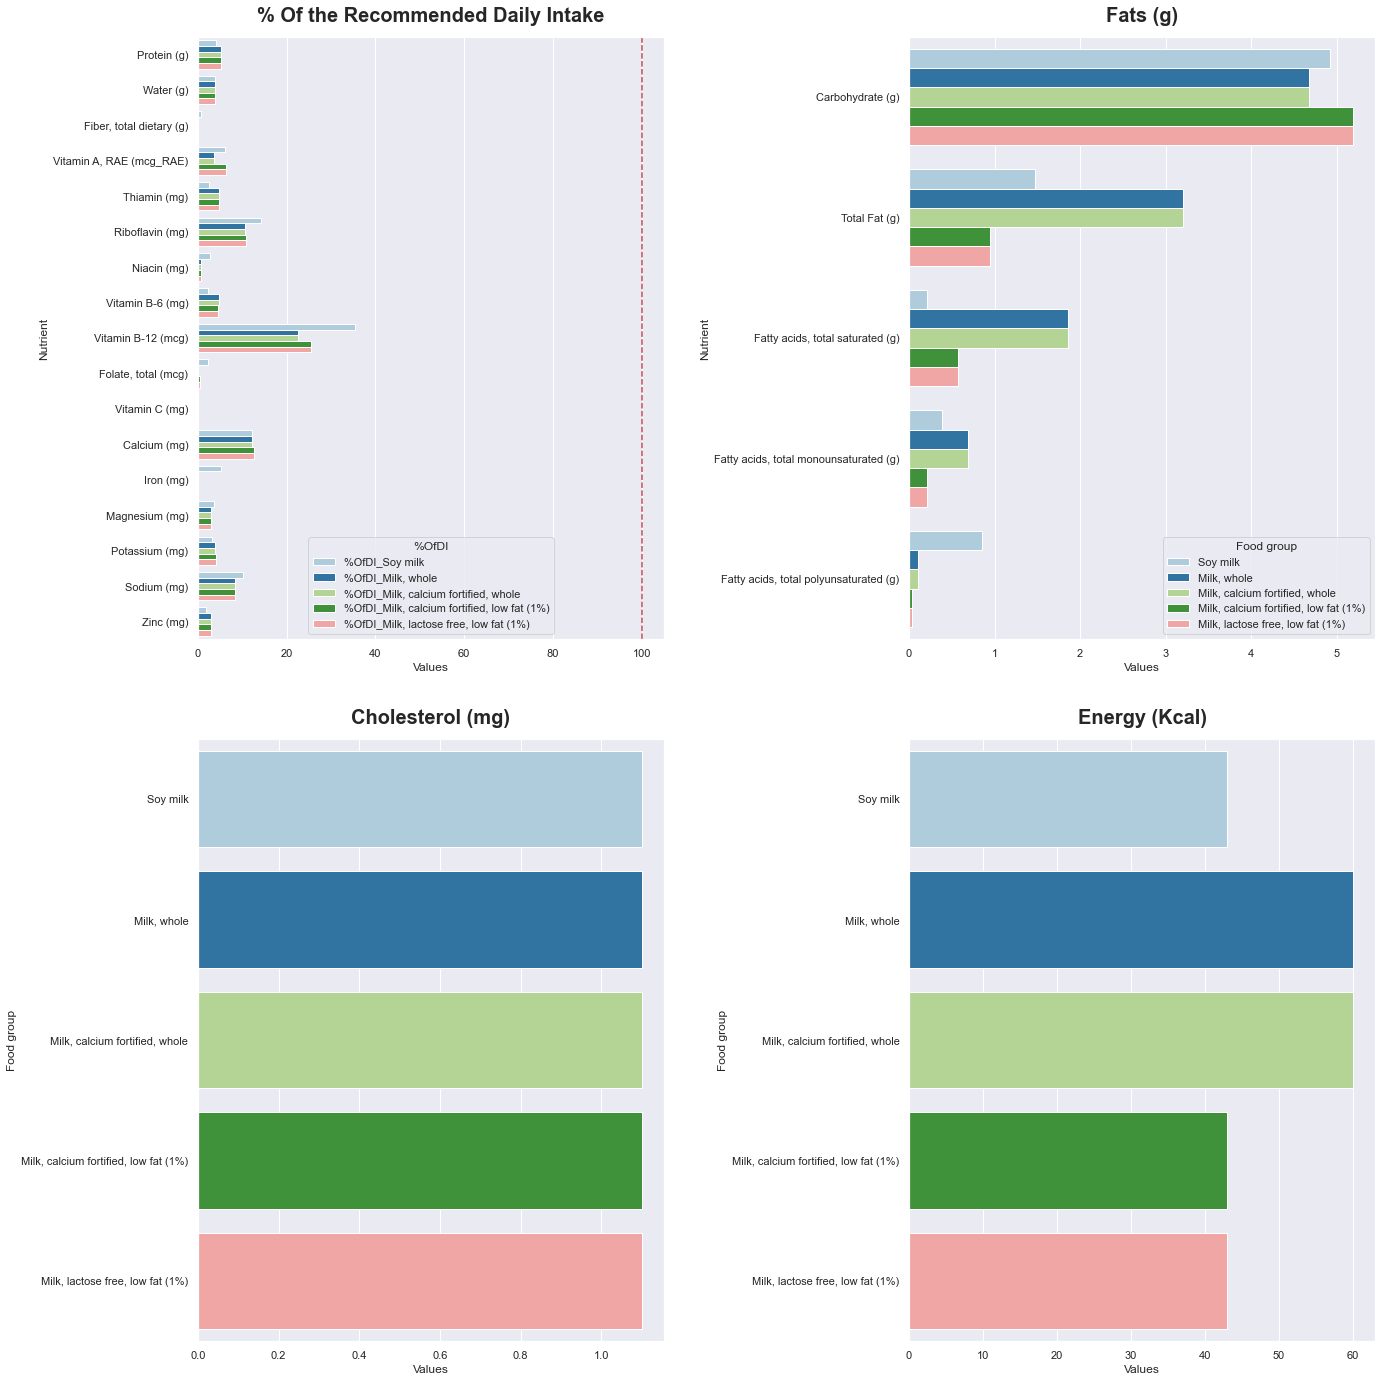

In [36]:
# We just need the new items to compare, and the nutrition_df 
foods = ["Soy milk", "Milk, whole", "Milk, calcium fortified, whole",
        "Milk, calcium fortified, low fat (1%)", "Milk, lactose free, low fat (1%)"]

# We calculate the comparison
comparison2 = md.full_comparison(male_30, nutrition_df, foods)

# We plot this
vis.full_comparison_plot(comparison2)
plt.show()

Now we can see better how soy milk not only is as nutritional as other milks, but it even outperform most of milks in several categories, such as: Vitamin-A, Riboflavin, Vitamin-B12. And on top of all this, at a lower saturated-fat cost (I focus on this one because it's the one that should be avoided).

Now let's do this with the different types of meat and their veggie counterparts.

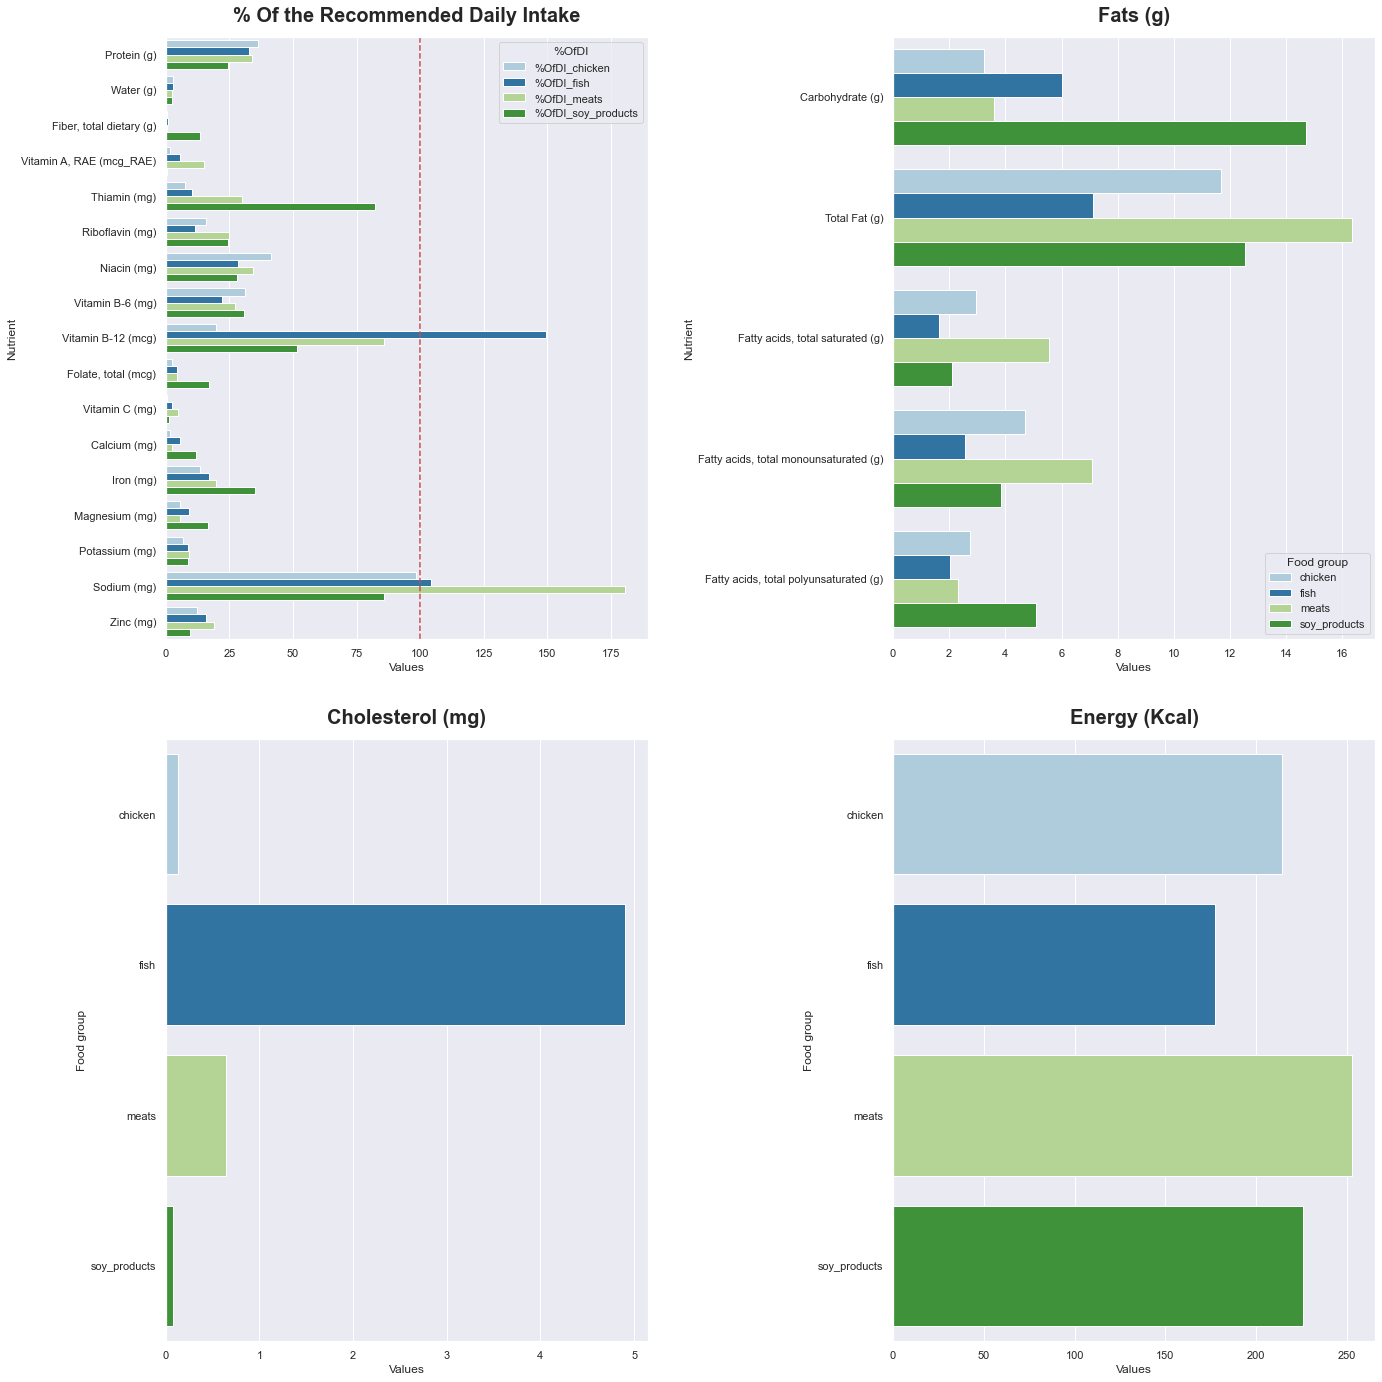

In [38]:
# Let's compare for instance, chicken, fish and meats vs soy_products

# We just need the new items to compare, and the nutrition_df 
foods_2 = ["chicken", "fish", "meats", "soy_products"]

# We calculate the comparison
comparison3 = md.full_comparison(male_30, stats, foods_2)

# We plot this
vis.full_comparison_plot(comparison3)
plt.show()

Now, several things we can comment on:

1 - Soy products have (in general) less protein than those coming from animal sources. However, we can see that the difference is no bigger than 10-15% in terms of filling the recommended daily intake. If we go back in the file, we will see that the cost of producing meat compared to tofu for instance, is way higher. So, it is clearly not an efficient option. We'll go deeper in to that.

2 - Soy products have half of the Vitamin B12, but 100g still help us reach above 50% of the necessary.

3 - Soy products are rich fiber, whereas no animal-product have any fiber.

4 - As before with the milk, we can see that the fat distribution for soy products goes mainly to unsaturated fats, performing better than almost anything but fish.

5 - Cholesterol based, it's definitely the best option.

We could go on with the comparisons, for instance with beans, as they are a very interesting option from a nutritional standpoint. However, we'll leave it here.

To conclude: we could see that animal-based options definitely have some advantages. This is undeniable. However, from a efficiency perspective, we (as socieaty) pay a too high price for these products, when we could find the missing nutrients in other cheaper (and also nutritious) options.

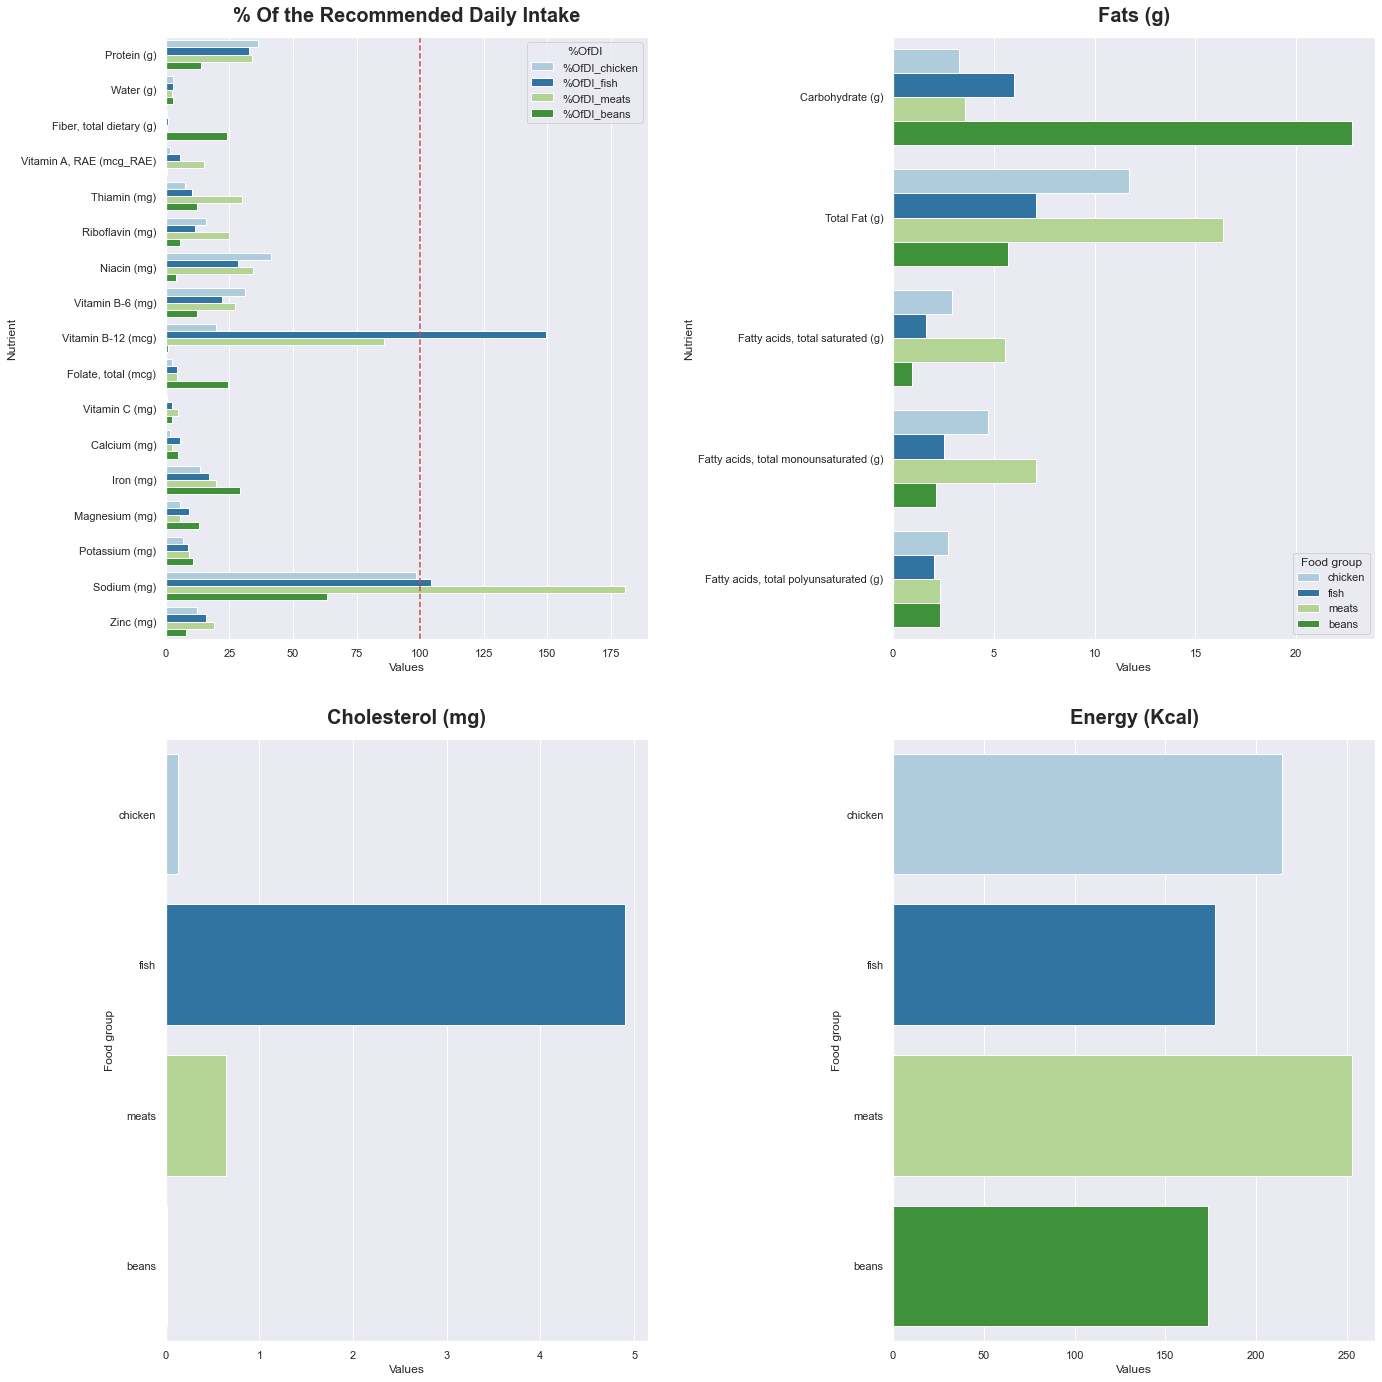

In [41]:
# Let's compare for instance, chicken, fish and meats vs soy_products

# We just need the new items to compare, and the nutrition_df 
foods_3 = ["chicken", "fish", "meats", "beans"]

# We calculate the comparison
comparison4 = md.full_comparison(male_30, stats, foods_3)

# We plot this
vis.full_comparison_plot(comparison4)
plt.show()